# Klasifikasi Sinyal Detak Jantung (Binary Classification)


In [ ]:
%pip install -q numpy pandas matplotlib seaborn scipy scikit-learn tensorflow

## 1. Business Understanding (Pemahaman Bisnis)

Tujuan Proyek: Tujuan utama dari proyek ini adalah untuk membangun model machine learning yang mampu mengklasifikasikan sinyal suara detak jantung menjadi dua kategori: Normal (sehat) dan Abnormal (memiliki patologi jantung seperti cacat katup atau penyakit arteri koroner).

Manfaat:

- Membantu tenaga medis dalam diagnosis awal penyakit jantung secara non-invasif.

- Mengurangi kesalahan manusia dalam auskultasi (mendengarkan detak jantung).

- Memungkinkan pemantauan pasien jarak jauh.

## 2. Data Understanding (Pemahaman Data)

Pada tahap ini, kita memuat data dari format .arff, memeriksa dimensi, keseimbangan kelas, dan memvisualisasikan bentuk gelombang sinyal untuk melihat perbedaan pola antara jantung normal dan abnormal

### Import Library

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

print("Library imported successfully")

Library imported successfully


### Load Data & Exploratory Data Analysis (EDA)

Dimensi Data Train: (204, 18531)
Dimensi Data Test: (205, 18531)

Distribusi Kelas pada Data Train:
target
Abnormal    149
Normal       55
Name: count, dtype: int64


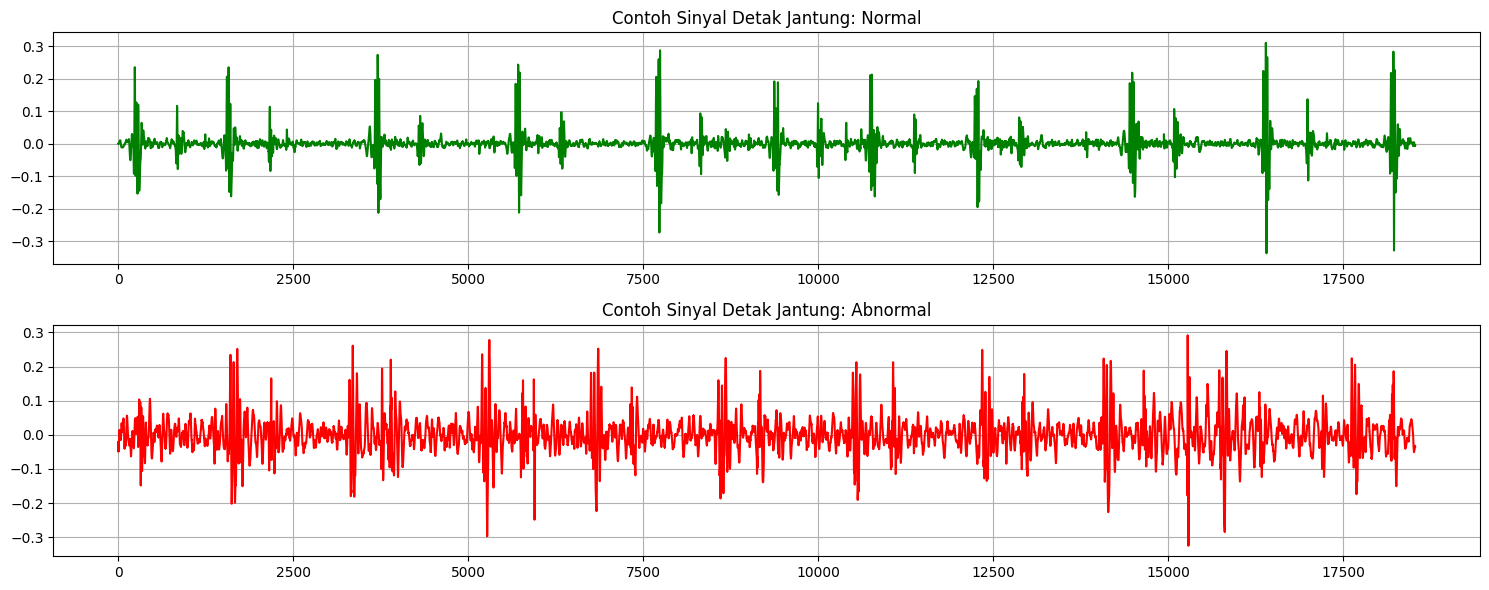

In [10]:
# Fungsi untuk memuat data ARFF ke Pandas DataFrame
def load_arff_data(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    # Decode byte strings ke normal strings jika diperlukan (biasanya kolom target)
    for col in df.select_dtypes([object]):
        df[col] = df[col].str.decode('utf-8')
    return df


# Memuat data Train dan Test
df_train = load_arff_data('./data/BinaryHeartbeat_TRAIN.arff')
df_test = load_arff_data('./data/BinaryHeartbeat_TEST.arff')

print(f"Dimensi Data Train: {df_train.shape}")
print(f"Dimensi Data Test: {df_test.shape}")

# Cek distribusi kelas
target_col = df_train.columns[-1]  # Asumsi kolom terakhir adalah target
print("\nDistribusi Kelas pada Data Train:")
print(df_train[target_col].value_counts())

# Visualisasi Sinyal
plt.figure(figsize=(15, 6))

# Ambil satu contoh Normal dan satu Abnormal
normal_signal = df_train[df_train[target_col] == 'Normal'].iloc[0, :-1].values
abnormal_signal = df_train[df_train[target_col] == 'Abnormal'].iloc[0, :-1].values

# Plot
plt.subplot(2, 1, 1)
plt.plot(normal_signal, color='green')
plt.title("Contoh Sinyal Detak Jantung: Normal")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(abnormal_signal, color='red')
plt.title("Contoh Sinyal Detak Jantung: Abnormal")
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Data detak jantung memiliki dimensi sangat tinggi (18.530 fitur waktu) dengan jumlah sampel yang sedikit (409 sampel). Preprocessing yang dilakukan:

1. Label Encoding: Mengubah label 'Normal'/'Abnormal' menjadi 0/1.

2. Reshaping: Mengubah bentuk data agar sesuai input model CNN 1D (Samples, Time Steps, Features).

In [11]:
# Memisahkan Fitur (X) dan Target (y)
X_train = df_train.iloc[:, :-1].values
y_train_raw = df_train.iloc[:, -1].values

X_test = df_test.iloc[:, :-1].values
y_test_raw = df_test.iloc[:, -1].values

# Encoding Label: Normal -> 0, Abnormal -> 1
# Catatan: Kita perlu memastikan mapping konsisten
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

print("Mapping Kelas:", dict(zip(le.classes_, le.transform(le.classes_))))

# Reshape untuk CNN
# CNN 1D membutuhkan input 3D: (Jumlah Sampel, Panjang Time Series, Jumlah Channel)
# Channel = 1 karena ini sinyal mono (amplitude)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nShape input CNN Train: {X_train_cnn.shape}")
print(f"Shape input CNN Test: {X_test_cnn.shape}")

Mapping Kelas: {'Abnormal': np.int64(0), 'Normal': np.int64(1)}

Shape input CNN Train: (204, 18530, 1)
Shape input CNN Test: (205, 18530, 1)


## 4. Modeling (Pemodelan Data)

Kita akan menggunakan 1D-CNN (Convolutional Neural Network). Alasan Pemilihan Model:

- Data berupa Time Series panjang. CNN sangat efisien dalam mengekstrak fitur lokal (pola gelombang) dari data sekuensial panjang tanpa terbebani jumlah parameter yang meledak seperti pada Fully Connected Network.

- Karena datanya sedikit (High Dimensionality, Low Sample Size), kita menggunakan arsitektur sederhana dengan Dropout untuk mencegah overfitting.

### Membangun dan Melatih Model CNN

In [ ]:
# Membersihkan sesi background keras
tf.keras.backend.clear_session()

# Inisialisasi Model
model = Sequential()

# Layer Konvolusi 1
model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(18530, 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))  # Mengurangi Overfitting

# Layer Konvolusi 2
model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))

# Layer Konvolusi 3 (Opsional, untuk menangkap fitur lebih kompleks)
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
# Mengurangi dimensi drastis sebelum masuk dense layer
model.add(GlobalAveragePooling1D())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer (Binary Classification: Sigmoid)
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Training Model
# Kita gunakan EarlyStopping agar training berhenti jika tidak ada perbaikan validasi
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=16,  # Batch size kecil karena data sedikit
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18521, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4630, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4630, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4621, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1155, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1155, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1146, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,265 (434.63 KB)

 Trainable params: 111,265 (434.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.6912 - loss: 0.6712 - val_accuracy: 0.7317 - val_loss: 0.6315
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.7304 - loss: 0.6172 - val_accuracy: 0.7317 - val_loss: 0.5929
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.7304 - loss: 0.5973 - val_accuracy: 0.7317 - val_loss: 0.5908
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.7304 - loss: 0.5931 - val_accuracy: 0.7317 - val_loss: 0.5838
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.7304 - loss: 0.5865 - val_accuracy: 0.7317 - val_loss: 0.5877
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.7304 - loss: 0.5994 - val_accuracy: 0.7317 - val_loss: 0.5843
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.7304 - loss: 0.5881 - val_accuracy: 0.7317 - val_loss: 0.5784
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.7304 - loss: 0.5881 - val_accuracy: 0.

### Visualisasi Training History

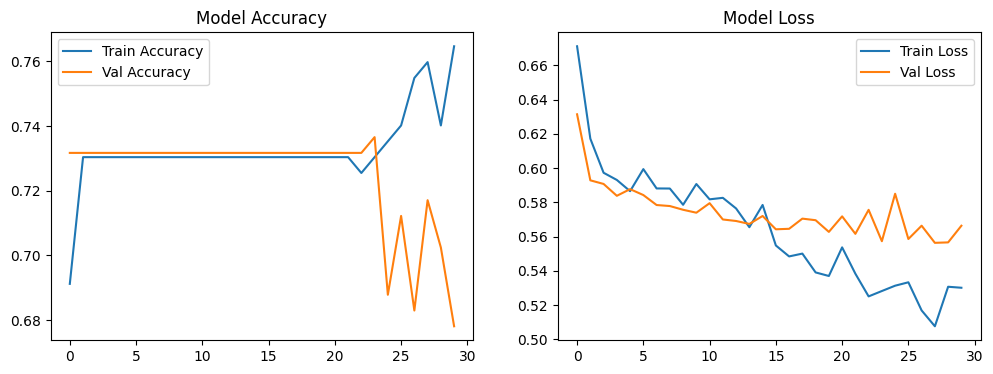

In [14]:
# Plot Accuracy dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

## 5. Evaluation (Evaluasi)
Mengevaluasi performa model menggunakan data Test yang belum pernah dilihat model sebelumnya.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Abnormal       0.74      0.93      0.83       150
      Normal       0.41      0.13      0.19        55

    accuracy                           0.72       205
   macro avg       0.58      0.53      0.51       205
weighted avg       0.66      0.72      0.66       205



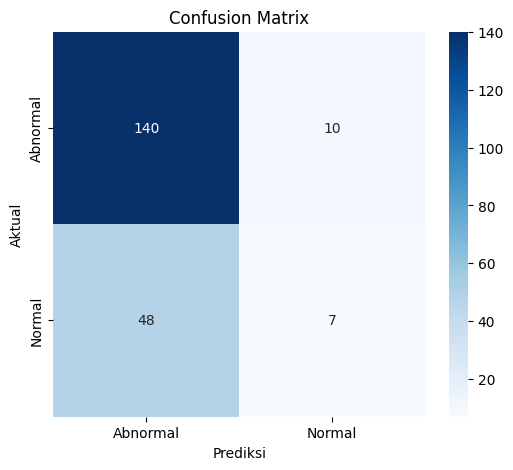

Model berhasil disimpan sebagai 'heartbeat_cnn_model.h5'


In [15]:
# Prediksi
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification Report
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# Simpan model untuk deployment
model.save('model/heartbeat_cnn_model.h5')
print("Model berhasil disimpan sebagai 'heartbeat_cnn_model.h5'")